# Week 3: Clustering

**Student Name 1, Student Name 2**

In this workshop, we will work through a set of problems on clustering, another cannonical form of unsupervised learning. Clustering is an important tool that is used to discover homogeneous groups of data points within a heterogeneous population. It can be the main goal in some problems, while in others it may be used in EDA to understand the main types of behavior in the data or in feature engineering.   

We will start by generating some artificial data, and then we will utilize clustering algorithms described in lectures and explore the impact of feature engineering on the solution. We will then attempt to find clusters in a gene expression dataset. 

As usual, the worksheets will be completed in teams of 2-3, using **pair programming**, and we have provided cues to switch roles between driver and navigator. When completing worksheets:

>- You will have tasks tagged by (CORE) and (EXTRA). 
>- Your primary aim is to complete the (CORE) components during the WS session, afterwards you can try to complete the (EXTRA) tasks for your self-learning process. 
>- Look for the 🏁 as cue to switch roles between driver and navigator.

Instructions for submitting your workshops can be found at the end of worksheet. As a reminder, **you must submit a pdf of your notebook on Learn by 16:00 PM on the Friday** of the week the workshop was given. 

As you work through the problems it will help to refer to your lecture notes (navigator). The exercises here are designed to reinforce the topics covered this week. Please discuss with the tutors if you get stuck, even early on! 

## Outline

1. [Problem Definition and Setup: Simulated Example](#setup1)
2. [K-means: Simulated Example](#kmeans1)
3. [Hierarchical Clustering: Simulated Example](#hc)
4. [Gene Expression Data](#genedata)
5. [Hierarchical Clustering: Gene Expression Data](#hc_genedata)
6. [K-means Clustering: Gene Expression Data](#kmeans_genedata)

# Problem Definition and Setup: Simulated Example <a id='setup1'></a>

## Packages

First, lets load in some packages to get us started. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns 

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

## Data: Simulated Example

We will begin with a simple simulated example in which there are truly three clusters. We assume that there are $D=2$ features and within each cluster, the data points are generated from a spherical normal distribution $N(\mathbf{m}_k, \sigma^2_k \mathbf{I})$ for clusters $k=1,2,3$, where both the mean $\mathbf{m}_k$ and variance $\sigma^2_k$ are different across clusters. Specifically, we assume that: 

* Cluster 1: contains $|C_1|=500$ points with mean vector $\mathbf{m}_1 = \begin{pmatrix} 0 \\ 4 \end{pmatrix}$ with standard deviation $\sigma_1 = 2$.
* Cluster 2: contains $|C_2|=250$ points with mean vector $\mathbf{m}_2 = \begin{pmatrix} 0 \\ -4 \end{pmatrix}$ with standard deviation $\sigma_2 = 1$.
* Cluster 3: contains $|C_3|=100$ points with mean vector $\mathbf{m}_3 = \begin{pmatrix} -4 \\ 0 \end{pmatrix}$ with standard deviation $\sigma_3 = 0.5$.

Run the following code to generate the dataset described above.

In [2]:
# Number of features
D = 2

# Cluster sizes
N_1 = 500
N_2 = 250
N_3 = 100

# Cluster means
m_1 = np.array([0., 4.])
m_2 = np.array([0., -4.])
m_3 = np.array([-4., 0.])

# Cluster standard deviations
sd_1 = 2.
sd_2 = 1.
sd_3 = 0.5

# Generate the data
rnd = np.random.RandomState(5)
X_1 = rnd.normal(loc = m_1, scale = sd_1, size = (N_1,D))
X_2 = rnd.normal(loc = m_2, scale = sd_2, size = (N_2,D))
X_3 = rnd.normal(loc = m_3, scale = sd_3, size = (N_3,D))
X = np.vstack((X_1, X_2, X_3))

# Save true cluster labels
cl = np.hstack((np.repeat(1,N_1),np.repeat(2,N_2),np.repeat(3,N_3)))

In [3]:
# Check that the size is correct
print(X.shape)

(850, 2)


### 🚩 Exercise 1 (CORE)

Visualise the data and color by the true cluster labels.

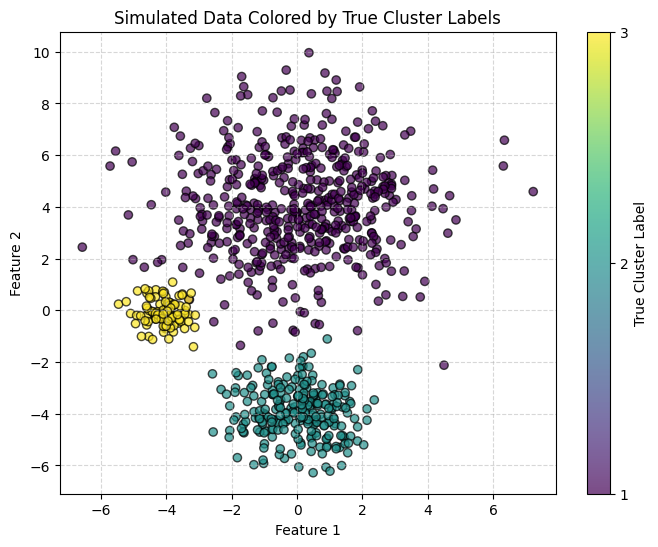

In [4]:
# Code for answer here!
plt.figure(figsize=(8, 6))

# Plot the data
# X[:, 0] gets all rows for the first feature (x-axis)
# X[:, 1] gets all rows for the second feature (y-axis)
# c=cl maps the colors to the cluster labels
scatter = plt.scatter(X[:, 0], X[:, 1], c=cl, cmap='viridis', alpha=0.7, edgecolors='k')

# Add a legend/colorbar to show which color corresponds to which cluster
plt.colorbar(scatter, label='True Cluster Label', ticks=[1, 2, 3])

# Add titles and labels for clarity
plt.title('Simulated Data Colored by True Cluster Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

# K-means Clustering: Simulated Example <a id='kmeans1'></a>

To perform K-means clustering, we will use `KMeans()` in `sklearn.cluster`. Documentation is available [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), and for an overview of clustering methods available in `sklearn`, see [link](https://scikit-learn.org/stable/modules/clustering.html). There are different inputs we can specify when calling `KMeans()` such as:

- `n_clusters`: the number of clusters. 
- `init`: which specifies the intialization of the centroids, e.g. can be set to `k-means++` for K-means++ initialization or `random` for random initialization.
- `n_init`: which specifies the number of times the algorithm is run with different random initializations
- `random_state`: this can bet set to a fixed number to make results reproducible.

We can then use the `.fit()` method of `KMeans` to run the K-means algorithm on our data.

After fitting, some of the relevant attributes of interest include:

- `labels_`: cluster assignments of the data points.
- `cluster_centers_`: mean corresponding to each cluster, stored in a matrix of size: number of clusters $K$ times number features $D$.
- `inertia_`: the total within-cluster variation.

We can also call the methods `.transform()` and `.predict()` on our fitted `KMeans()` objects. The former transforms/encodes an $N \times D$ feature matrix into an $N \times C$ matrix, where the new features reprent the distance to cluster $c$, for $c=1,\ldots, C$. The later predicts the cluster labels of each sample in  an $N \times D$ feature matrix (i.e. returns the index of the closest cluster).

### 🚩 Exercise 2 (CORE)

Let's start by exploring how the clustering changes across the K-means iterations. To do, set:

- number of clusters to 3
- initialization to random
- number of times the algorithm is run to 1
- fix the random seed to a number of your choice (e.g. 0)


a) Now, fit the K-means algorithms with different values of the maximum number of iterations fixed to 1,2,3, and the default value of 300. 

b) Plot the data points colored by cluster for the four different cases and mark the cluster centers to observe how the clustering solution changes across iterations. 

c) How many iterations are needed for the convergence?
<br><br>
<details><summary><b><u>Hint</b></u></summary>
    
- To find the number of iterations, check the attributes of [`KMeans`](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html)
    
</details>

In [5]:
# Part a: Code for answer here!
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
# List of max_iter values to test
iter_values = [1, 2, 3, 300]
models = []

# Loop through and fit a model for each max_iter value
for i in iter_values:
    # Initialize KMeans
    kmeans = KMeans(n_clusters=3,
                    init='random',
                    n_init=1,
                    random_state=0,
                    max_iter=i)
    
    # Fit the model to the data X
    kmeans.fit(X)
    
    # Store the fitted model for Part B
    models.append(kmeans)

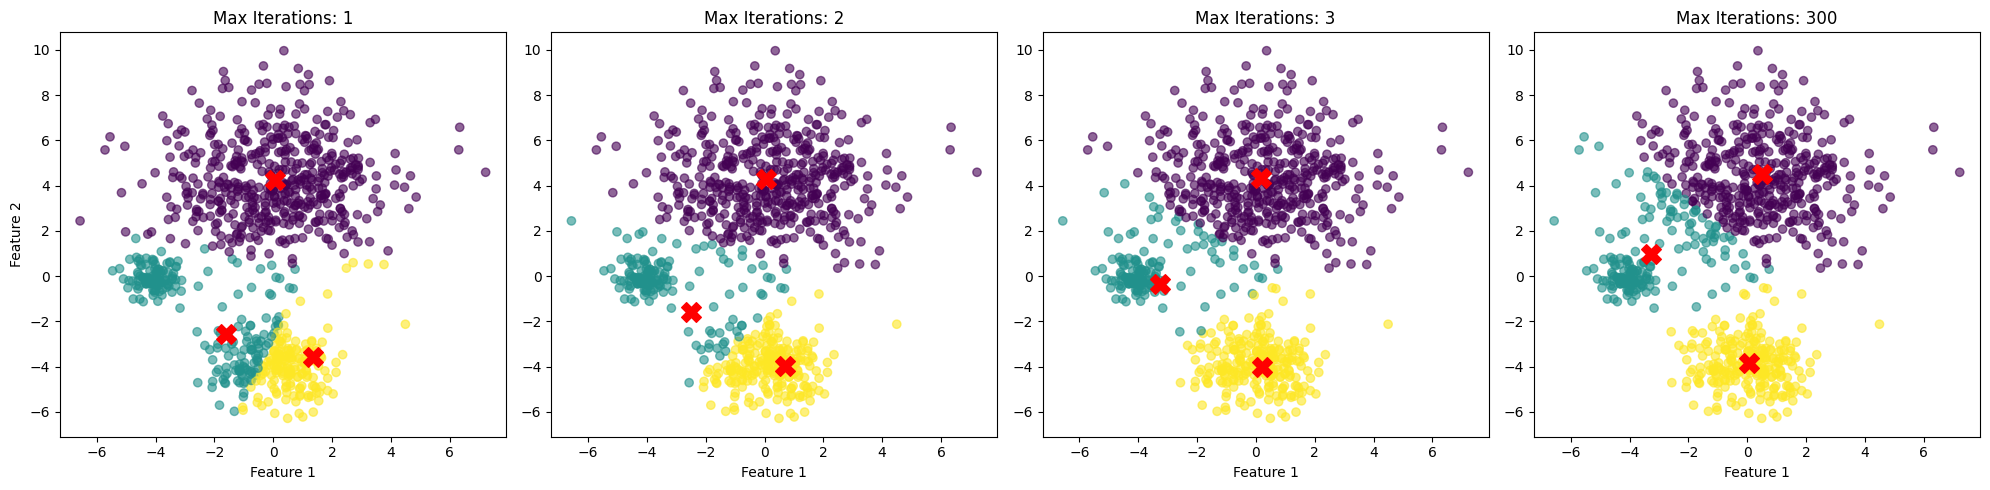

In [6]:
# Part b: Code for answer here!
# Create a figure with subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, model in enumerate(models):
    ax = axes[idx]
    
    # Plot the data points colored by their predicted cluster label
    ax.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap='viridis', alpha=0.6)
    
    # Mark the cluster centers
    centers = model.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label='Centroids')
    ax.set_title(f'Max Iterations: {iter_values[idx]}')
    ax.set_xlabel('Feature 1')
    if idx == 0:
        ax.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [7]:
# Part c: Code for answer here!
converged_model = models[-1]

print(f"Number of iterations needed for convergence: {converged_model.n_iter_}")

Number of iterations needed for convergence: 11


### 🚩 Exercise 3 (CORE)

Next, compare the random intialization with K-means++ (in this case fix the number of different initializations to 10). Plot both clustering solutions. Which requires fewer iterations? and which provides a lower within-cluster variation?

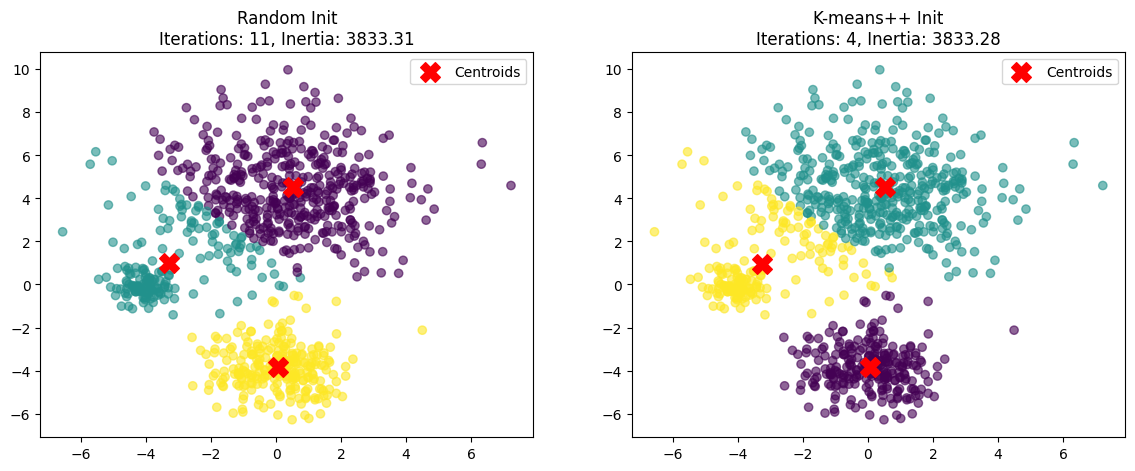

Random Init - Iterations: 11, Inertia: 3833.31
K-means++   - Iterations: 4, Inertia: 3833.28


In [8]:
# Code for answer here!
# Random Initialization
kmeans_random = KMeans(n_clusters=3, init='random', n_init=10, random_state=0)
kmeans_random.fit(X)

# K-means++ Initialization
kmeans_pp = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=0)
kmeans_pp.fit(X)

# Plotting the results side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Random Init
axes[0].scatter(X[:, 0], X[:, 1], c=kmeans_random.labels_, cmap='viridis', alpha=0.6)
axes[0].scatter(kmeans_random.cluster_centers_[:, 0], kmeans_random.cluster_centers_[:, 1], 
                c='red', s=200, marker='X', label='Centroids')
axes[0].set_title(f'Random Init\nIterations: {kmeans_random.n_iter_}, Inertia: {kmeans_random.inertia_:.2f}')
axes[0].legend()

# Plot K-means++ Init
axes[1].scatter(X[:, 0], X[:, 1], c=kmeans_pp.labels_, cmap='viridis', alpha=0.6)
axes[1].scatter(kmeans_pp.cluster_centers_[:, 0], kmeans_pp.cluster_centers_[:, 1], 
                c='red', s=200, marker='X', label='Centroids')
axes[1].set_title(f'K-means++ Init\nIterations: {kmeans_pp.n_iter_}, Inertia: {kmeans_pp.inertia_:.2f}')
axes[1].legend()

plt.show()

# Print comparison for the question
print(f"Random Init - Iterations: {kmeans_random.n_iter_}, Inertia: {kmeans_random.inertia_:.2f}")
print(f"K-means++   - Iterations: {kmeans_pp.n_iter_}, Inertia: {kmeans_pp.inertia_:.2f}")

_K-means++requires fewer iterations and can find lower Inertia._

### 🚩 Exercise 4 (CORE)

In the following two code cells, we compare the clustering solution using a different number of initializations equal to 1, 2, 5, 10, and 20 for kmeans++ initialization (first cell) and random initialization (second cell). 

Based on the results, comment on the preferred initialization strategy and how many intializations are needed? Try changing the random state; how does that change your conclusions?

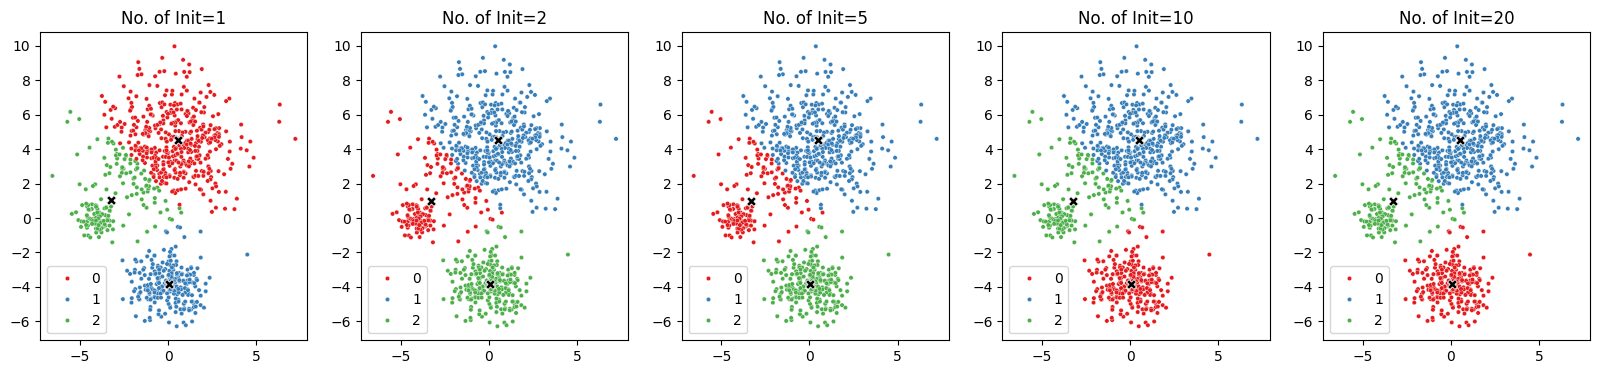

WCV=3833.368 for no. of init =1
WCV=3833.3076 for no. of init =2
WCV=3833.3076 for no. of init =5
WCV=3833.2826 for no. of init =10
WCV=3833.2826 for no. of init =20


In [9]:
# Kmeans++ initialization
# Plotting the clustering solution with different number of initializations 
n_init = np.array([1,2,5,10,20])

rs = 0

fig, ax = plt.subplots(1,n_init.shape[0],figsize=(20,4))
for n in range(n_init.shape[0]):
    kmeans_n = KMeans(n_clusters = 3, n_init = n_init[n], random_state=rs).fit(X)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=kmeans_n.labels_, palette='Set1', s=10, ax=ax[n])
    sns.scatterplot(x=kmeans_n.cluster_centers_[:,0], y=kmeans_n.cluster_centers_[:,1], 
                    c='black', s=50, marker='X', ax=ax[n])
    ax[n].set_title("No. of Init="+str(n_init[n]))
plt.show()

# Print the within cluster variation
for n in range(n_init.shape[0]):
    kmeans_n = KMeans(n_clusters = 3, n_init = n_init[n], random_state=rs).fit(X)
    print("WCV="+str(round(kmeans_n.inertia_,4))+' for no. of init ='+ str(n_init[n]))


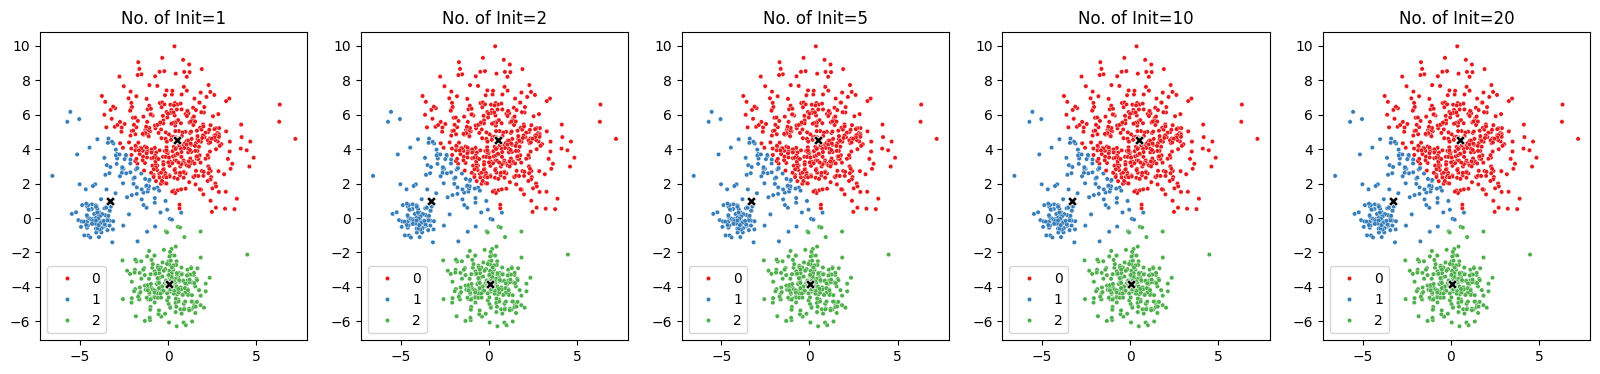

WCV=3833.3076 for no. of init =1
WCV=3833.3076 for no. of init =2
WCV=3833.3076 for no. of init =5
WCV=3833.3076 for no. of init =10
WCV=3833.3076 for no. of init =20


In [10]:
# Random initialization
# Plotting the clustering solution with different number of initializations 
n_init = np.array([1,2,5,10,20])

rs = 0

fig, ax = plt.subplots(1,n_init.shape[0],figsize=(20,4))
for n in range(n_init.shape[0]):
    kmeans_n = KMeans(n_clusters = 3, init = 'random', n_init = n_init[n], random_state=rs).fit(X)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=kmeans_n.labels_, palette='Set1', s=10, ax=ax[n])
    sns.scatterplot(x=kmeans_n.cluster_centers_[:,0], y=kmeans_n.cluster_centers_[:,1], 
                    c='black', s=50, marker='X', ax=ax[n])
    ax[n].set_title("No. of Init="+str(n_init[n]))
plt.show()

# Print the within cluster variation
for n in range(n_init.shape[0]):
    kmeans_n = KMeans(n_clusters = 3, init = 'random',n_init = n_init[n], random_state=rs).fit(X)
    print("WCV="+str(round(kmeans_n.inertia_,4))+' for no. of init ='+ str(n_init[n]))

_K-means++ K-means++ is the preferred strategy. Looking at the WCV (Within-Cluster Variation) values printed below your plots, K-means++ achieved the lowest error of 3833.2826 (at n_init=10). In contrast, the Random initialization (with this specific seed) got stuck at a slightly worse solution with a WCV of 3833.3076 across the board. K-means++ intelligently selects initial centroids to be far apart, which generally leads to faster convergence and a higher probability of finding the global optimum (lowest WCV) compared to the pure luck of Random initialization.\
For K-means++: 10 initializations seem to be the "sweet spot" in your results. The WCV stabilized at its minimum value (3833.2826) by n_init=10. The default in scikit-learn (which is 10) works well. For Random: You typically need a much higher number (often >20) to ensure robustness, as it relies entirely on chance. In your specific output, even 20 wasn't enough to beat the K-means++ result.\
Effect of changing the Random State If you were to change the random_state: Random Initialization: You would likely see high variance in the results, especially for low n_init. Some seeds might result in very poor clustering (high WCV) where centroids get stuck in one corner, while others might get lucky and match K-means++. K-means++: The results would remain consistent and stable. Because the initialization is algorithmic rather than purely random, it will produce good results regardless of the random seed._

🏁 **Now, is a good point to switch driver and navigator**

### 🚩 Exercise 5 (CORE)

Since we simulated the data, we know the true number of clusters. However, in practice this number is rarely known. Find the K-means solution with different choices of $K$ and plot the within-cluster variation as a function of $K$. What value(s) of $K$ seem appropriate based on this plot?

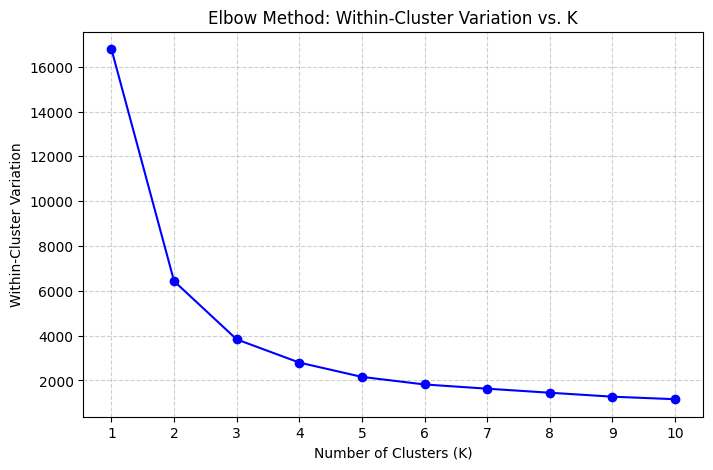

In [11]:

# Code for answer here!
wcv = []

# Define the range of K values to test
k_values = range(1, 11)

# Loop through each K value
for k in k_values:
    # Initialize and fit the model
    # We use k-means++ as established in Exercise 4
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=0)
    kmeans.fit(X)
    
    # Append the inertia (WCV) to our list
    wcv.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcv, marker='o', linestyle='-', color='b')
plt.title('Elbow Method: Within-Cluster Variation vs. K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Variation')
plt.xticks(k_values)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

_The plot suggests that $K=3$ is the most appropriate number of clusters.Reasoning:The "Elbow" Point: The curve shows a steep decrease in Within-Cluster Variation (inertia) as $K$ moves from 1 to 3. At $K=3$, the curve forms a distinct "elbow" where the slope abruptly flattens.Diminishing Returns: Beyond $K=3$, increasing the number of clusters yields only small reductions in variation. This indicates that adding more clusters is just subdividing the data unnecessarily rather than capturing true underlying patterns.Verification: This result matches the ground truth of our simulated dataset, which we explicitly generated with 3 clusters._

### 🚩 Exercise 6 (CORE)

Now let's use the silhouette analysis to choose the number of clusters. In the follwing code cells, we use [`silhouette_samples`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html) to compute the silhouette coefficient for each data point, and [`silhouette_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) which computes the mean of the silhouette coefficients across all data points.

a) How many clusters would you choose based only on maximizing the silhouette score?

b) Considering also the violin plots, which visualize the distribution of the silhouette coefficient across data points within each cluster, would you still choose the same number of clusters or pick a different number? Why?

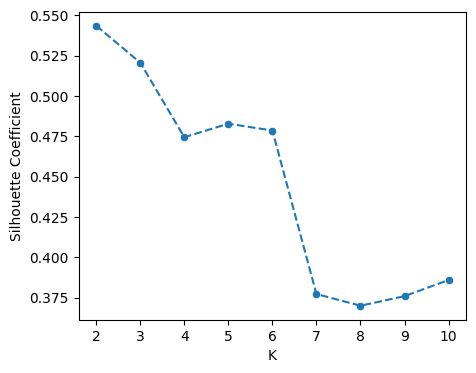

In [12]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Define the range of possible number ofclusters
K = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10])

# First plot the silhouette coeffcient for different choices of K
silhouette_coeffs = np.zeros(K.shape)
for i in range(K.shape[0]):
    #Define kmeans object, fit, and predict labels
    kmeans_K = KMeans(n_clusters = K[i], n_init = 20, random_state=0).fit(X)
    labs = kmeans_K.predict(X)
    # Compute silhouette coefficient
    silhouette_coeffs[i] = silhouette_score(X, labs)

# Plot the silhouette coefficients
fig, ax = plt.subplots(1,1,figsize=(5,4))
sns.lineplot(x=K, y=silhouette_coeffs, linestyle='dashed', ax=ax)
sns.scatterplot(x=K, y=silhouette_coeffs, ax=ax)
plt.xlabel('K')
plt.ylabel('Silhouette Coefficient')
plt.show()

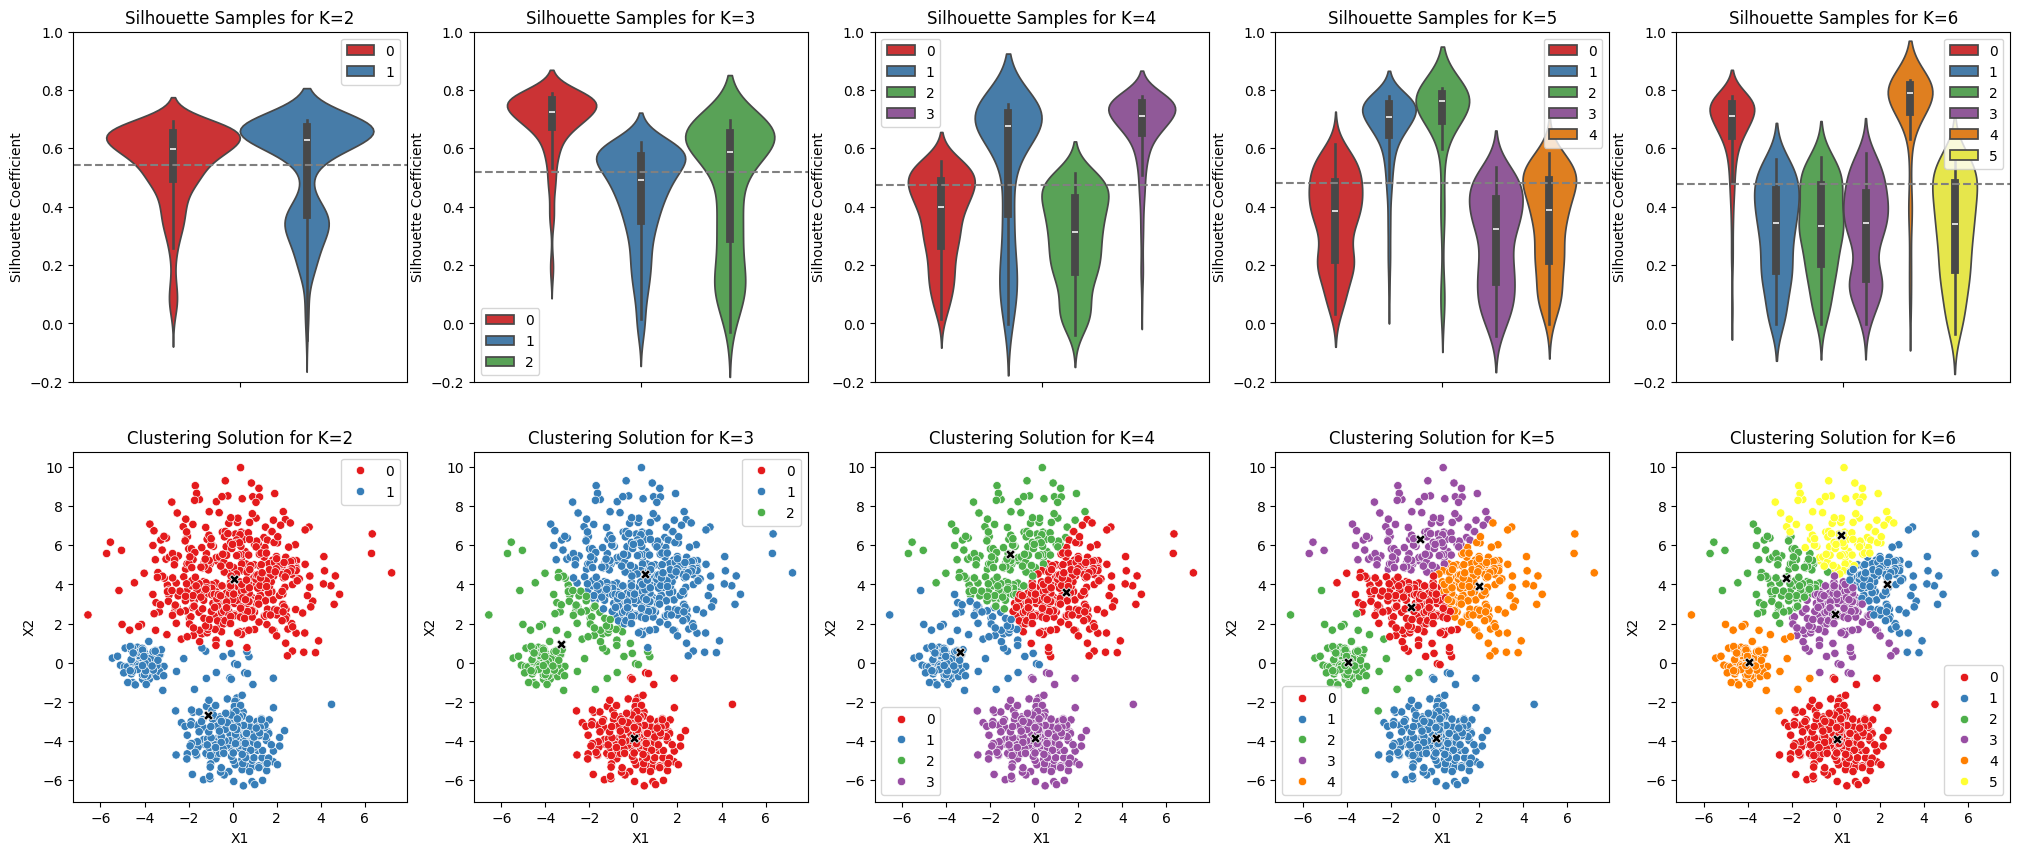

In [13]:
# Plot the silhouette samples for different choices of K

max_i = 4
fig, ax = plt.subplots(2, 5, figsize=(25, 10))  
for i in range(max_i+1):
    kmeans_K = KMeans(n_clusters = K[i], n_init = 20, random_state=0).fit(X)
    labs = kmeans_K.predict(X)
    silhouette_samps = silhouette_samples(X, labs)

    # Create a violin plot of the silhouette samples
    sns.violinplot(y=silhouette_samps, hue=labs, ax=ax[0,i], palette='Set1')
    ax[0,i].axhline(silhouette_samps.mean(), ls='--',c="gray")
    ax[0,i].set_title(f'Silhouette Samples for K={K[i]}')
    ax[0,i].set_ylabel('Silhouette Coefficient')
    ax[0,i].set_xlabel('')
    ax[0,i].set_ylim([-0.2, 1])

    # Plot the clustering solution
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=labs, ax=ax[1,i], palette='Set1')
    sns.scatterplot(x=kmeans_K.cluster_centers_[:,0], y=kmeans_K.cluster_centers_[:,1], 
                    c='black', s=50, marker='X', ax=ax[1,i])
    ax[1,i].set_title(f'Clustering Solution for K={K[i]}')
    ax[1,i].set_ylabel('X2')
    ax[1,i].set_xlabel('X1')

_a) Based strictly on the line plot of the silhouette coefficients, I would choose $K = 2$, as it has the highest peak (approximately 0.54) compared to $K=3$ (approximately 0.52).\
b) I would choose a different number: $K = 3$.\
Reasoning:Visual Inspection ($K=2$ vs $K=3$): If you look at the scatter plot for $K=2$ (bottom left), the algorithm has incorrectly merged two distinct groups of data (the top two blobs) into a single cluster (the red points). This under-segments the data.Violin Plots: While $K=2$ has a high average score, the violin plots for $K=3$ show a more balanced quality across all groups.True Structure: The scatter plot for $K=3$ perfectly captures the three distinct natural groupings in the data. Since we know from the problem setup that the data was generated from 3 clusters, $K=3$ is clearly the correct structural choice, even if the raw silhouette score for $K=2$ is slightly higher due to the large separation distance between the bottom cluster and the top two._

### 🚩 Exercise 7 (CORE)

Now standardize the data and re-run the K-means algorithm. Qualitatively, how has standardising the data impacted performance? Can you argue why you observe what you see?

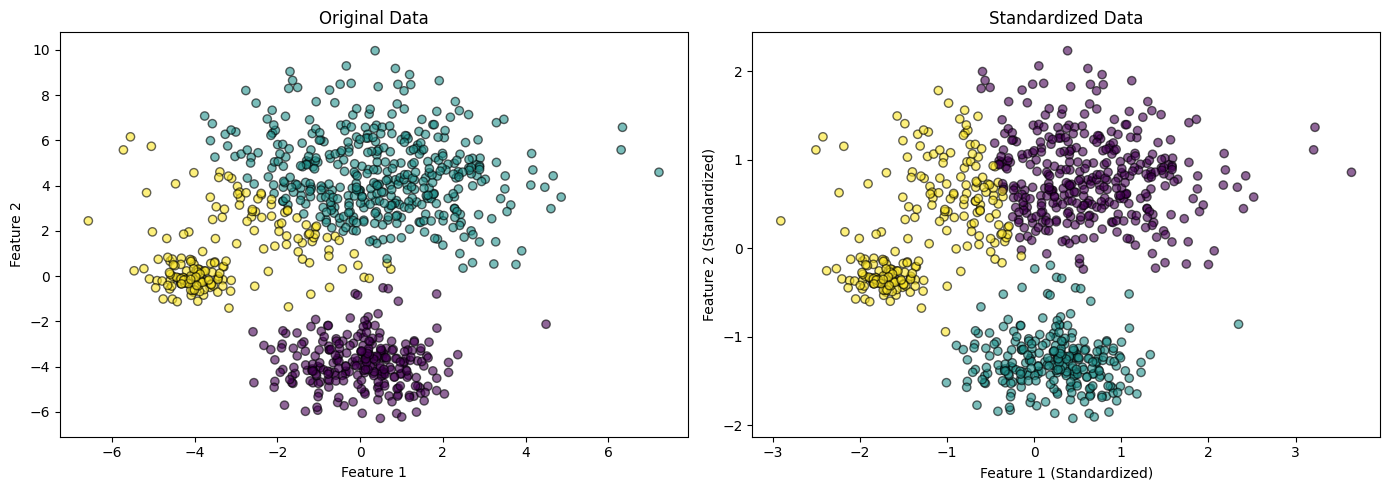

In [14]:
# Code for answer here!
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Re-run K-means on the standardized data
# We use K=3 as established in previous exercises
kmeans_std = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=0)
kmeans_std.fit(X_std)

# Plot the results to compare visually
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Original Data (re-fitting briefly for comparison)
kmeans_orig = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=0).fit(X)
ax1.scatter(X[:, 0], X[:, 1], c=kmeans_orig.labels_, cmap='viridis', alpha=0.6, edgecolors='k')
ax1.set_title('Original Data')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

# Plot Standardized Data
ax2.scatter(X_std[:, 0], X_std[:, 1], c=kmeans_std.labels_, cmap='viridis', alpha=0.6, edgecolors='k')
ax2.set_title('Standardized Data')
ax2.set_xlabel('Feature 1 (Standardized)')
ax2.set_ylabel('Feature 2 (Standardized)')

plt.tight_layout()
plt.show()

_Qualitative Impact on Performance: Qualitatively, standardizing the data has had little to no impact on the clustering performance in this specific case. The clusters remain well-separated and are identified correctly, just as they were with the original data.\
Reasoning: Standardization is critical when features have vastly different scales (e.g., one feature in millimeters and another in kilometers), as K-means relies on Euclidean distance and would otherwise be biased toward the feature with larger numerical values.\
However, in this simulated dataset, the two features (Feature 1 and Feature 2) already possess comparable scales and variances (they are both spatial coordinates with similar ranges). Because the features were already "balanced," standardizing them did not significantly distort or correct the relative distances between points, leading to a nearly identical clustering outcome._

# Hierarchical Clustering: Simulated Example <a id='hc'></a>

To perform hierarchical clustering, we will use the [`linkage()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) function from `scipy.cluster.hierarchy`. The inputs to specify include

-  the data. 
- `metric`: specifies the dissimarlity between data points. Defaults to the Euclidean distance.
- `method`: specifies the type of linkage, e.g. complete, single, or average.

Then, we can use [`dendrogram()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html) from `scipy.cluster.hierarchy` to plot the dendrogram.

Note that you can also use [`AgglomerativeClustering`](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.AgglomerativeClustering.html) from `sklearn.cluster`, which similarly has options for `metric` to specify the distance and `linkage` to specify the type of linkage. However, `sklearn` does not have its own functions for plotting the dendogram and use must use the tools from `scipy.cluster.hierarchy`.  

### 🚩 Exercise 8 (CORE)

a) For the following code cell, what is dissimarlity and linkage is used in hierarchical clustering?

In [15]:
hc_comp = hierarchy.linkage(X, method='complete')

In this hierarchical clustering, the dissimilarity measure used is the Euclidean distance. The linkage method used is complete linkage.

b)  Plot the dendogram by running the code below. Try changing the 'color_threshold' to a number (e.g. 11) to color the branches of the tree below the threshold with different colors. How many clusters are identified if the tree is cut at that threshold?

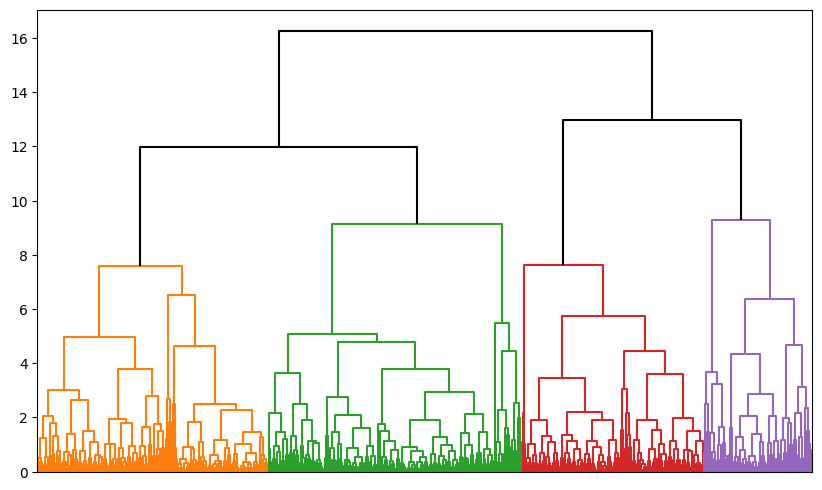

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
hierarchy.dendrogram(
    hc_comp,
    ax=ax,
    no_labels=True,
    color_threshold=11,
    above_threshold_color='black'
)
plt.show()


When the color_threshold is set to 11, the dendrogram is cut at this height. From the plot, we can see that 4 clusters are identified at this threshold and each colored branch represents one cluster.

c) Now, use the function `cut_tree()` from `scipy.cluster.hierarchy` to determine the cluster labels associated with a given cut of the dendrogram. You can either specify the number of clusters via `n_clusters` or the height/threshold at which to cut via `height`. Plot the data colored by the cluster labels.

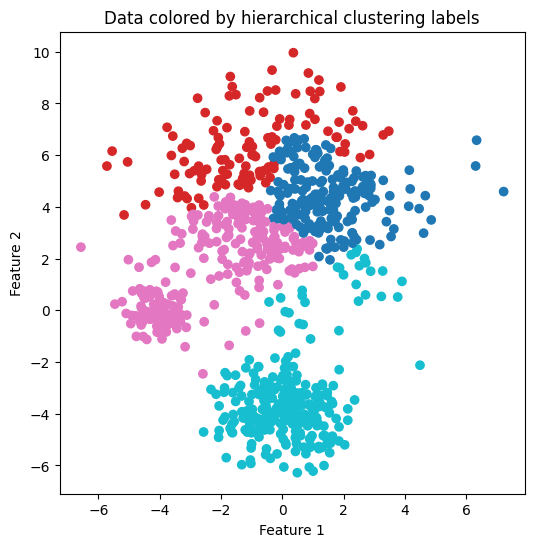

In [ ]:
from scipy.cluster.hierarchy import cut_tree

labels = cut_tree(hc_comp, n_clusters=4).flatten()

#Plot 
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data colored by hierarchical clustering labels')
plt.show()


### 🚩 Exercise 9 (CORE)

Now try changing the linkage to single and average. Does this affect on the results?

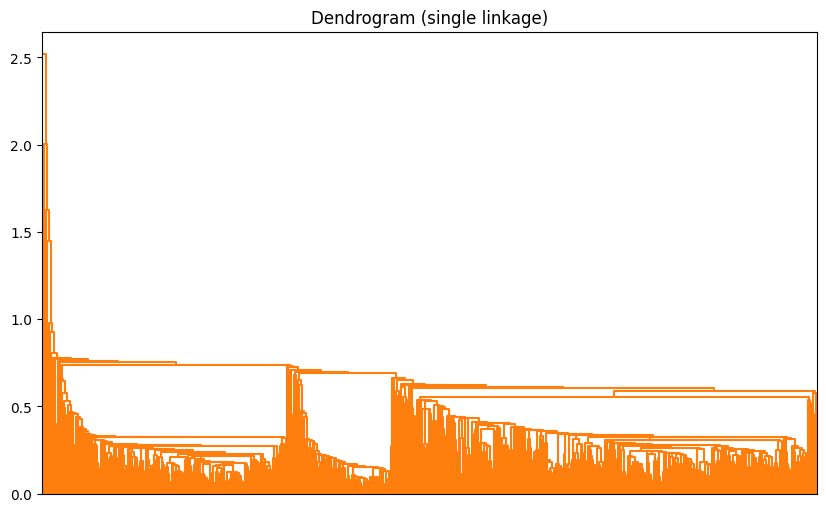

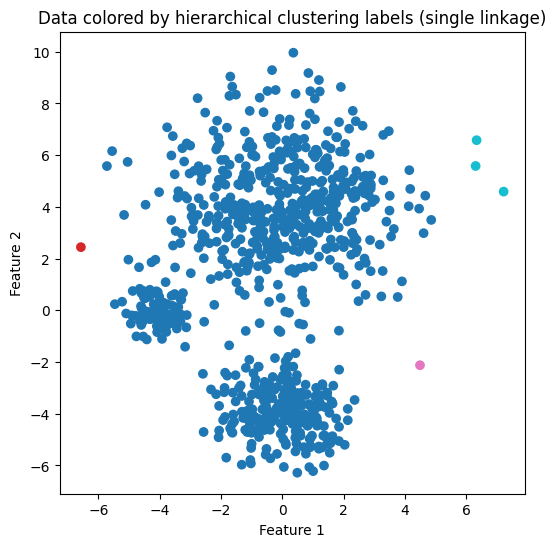

In [ ]:
hc_single = hierarchy.linkage(X, method='single')

# Plot 
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
hierarchy.dendrogram(
    hc_single,
    ax=ax,
    no_labels=True,
    color_threshold=11,
    above_threshold_color='black'
)
plt.title('Dendrogram (single linkage)')
plt.show()

# Cut tree into 4 clusters and plot data
labels_single = cut_tree(hc_single, n_clusters=4).flatten()

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels_single, cmap='tab10')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data colored by hierarchical clustering labels (single linkage)')
plt.show()


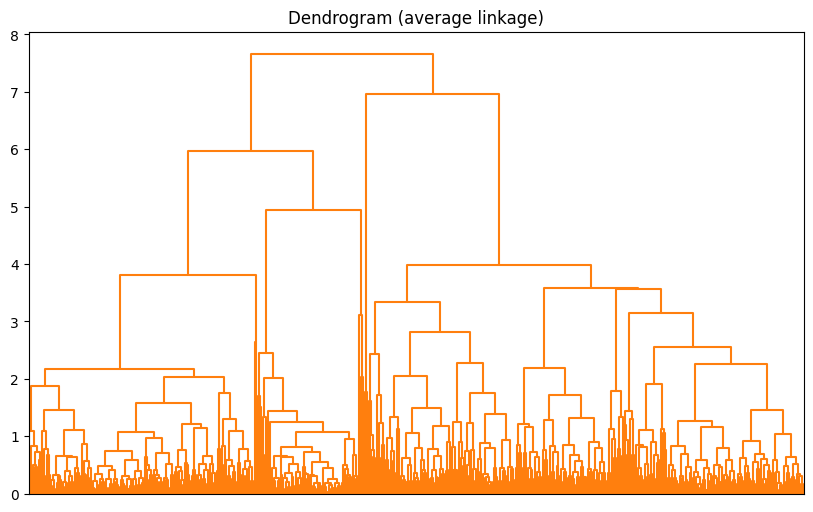

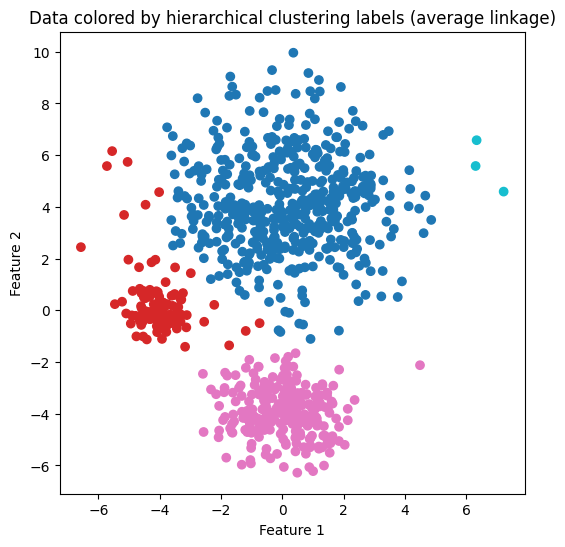

In [ ]:
hc_avg = hierarchy.linkage(X, method='average')

# Plot 
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
hierarchy.dendrogram(
    hc_avg,
    ax=ax,
    no_labels=True,
    color_threshold=11,
    above_threshold_color='black'
)
plt.title('Dendrogram (average linkage)')
plt.show()

# Cut tree into 4 clusters and plot data
labels_avg = cut_tree(hc_avg, n_clusters=4).flatten()

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels_avg, cmap='tab10')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data colored by hierarchical clustering labels (average linkage)')
plt.show()


Changing the linkage method from complete to single and average will significantly affect the clustering results.
Under single linkage, it shows the strong chaining effect. Most data points are grouped into one large cluster, and only a few points form small clusters. This clustering result is not very clear.
Under average linkage, the clustering result is more balanced. The clusters are better separated in space and the result is similar to complete linkage, but some differences can still be seen near the cluster boundaries.
We can see that the choice of linkage has a clear impact on hierarchical clustering results. Single linkage is sensitive to chaining, while average linkage gives more stable clusters.

🏁 **Now, is a good point to switch driver and navigator**

# Gene Expression Data <a id='genedata'></a>

Now, we will consider a more complex real dataset with a larger feature space. 

The dataset is the **NCI cancer microarray dataset** discussed in both *Introduction to Statistical Learning* and  *Elements of Statistical Learning*. The dataset consists of $D=6830$ gene expression measurements for each of $N=64$ cancer cell lines. The aim is to determine whether there are groups among the cell lines with similar gene expression patterns. This is an example of a high-dimensional dataset with $D$ much larger than $N$, which makes visualization difficult. The $N=64$ cancer cell lines have been obtained from samples of cancerous tisses, corresponding to 14 different types of cancer. However, our focus remains unsupervised learning and we will use the cancer labels only to plot. 

We first need to read in the dataset.

In [20]:
#Fetch the data and cancer labels
url_data = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/nci.data.csv'
url_labels = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/nci.label.txt'

X = pd.read_csv(url_data)
y = pd.read_csv(url_labels, header=None)

# clean data by dropping identifier column and transpose so that features are columns
X = X.drop(labels='Unnamed: 0', axis=1).T

In [21]:
X.shape

(64, 6830)

In [22]:
y.shape

(64, 1)

Let's visualise the data with a heatmap.

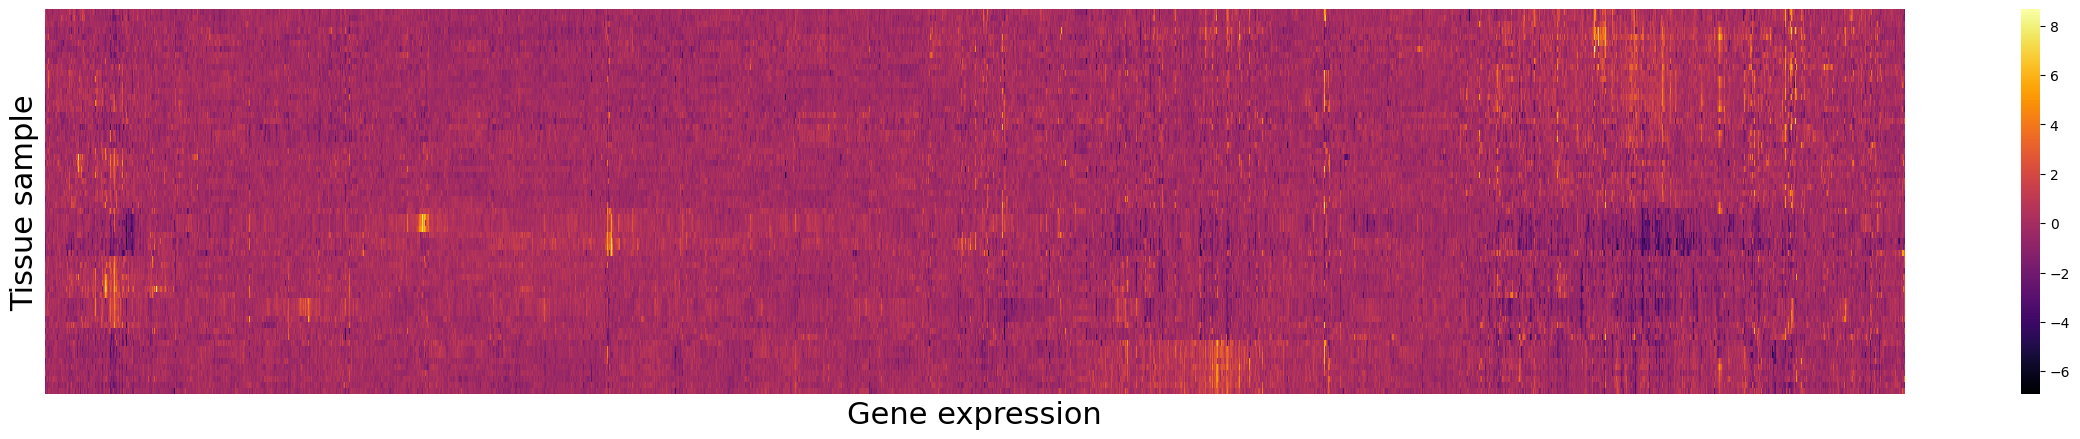

In [23]:
# Heatmap of the gene expression data
fig, ax = plt.subplots(1,1,figsize=(30,5))
sns.heatmap(X, cmap='inferno', ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("Gene expression", fontsize=22)
ax.set_ylabel("Tissue sample", fontsize=22)
plt.show()

We now convert our pandas dataframe into a numpy array and create integer labels for cancer type (for plotting purposes)

If you print the unique labels, you will notice there are lots of inconsistencies with white space etc. Run the following code to clean the labels.

In [24]:
# Print the unique labels and counts
y.value_counts()

0                         
OVARIAN                       4
RENAL                         4
MELANOMA                      3
COLON                         3
NSCLC                         3
BREAST                        2
CNS                           2
BREAST                        2
NSCLC                         2
NSCLC                         2
RENAL                         2
PROSTATE                      2
CNS                           2
MELANOMA                      2
LEUKEMIA                      2
COLON                         2
MELANOMA                      2
BREAST                        1
BREAST                        1
BREAST                        1
CNS                           1
LEUKEMIA                      1
COLON                         1
COLON                         1
MCF7D-repro                   1
LEUKEMIA                      1
LEUKEMIA                      1
MCF7A-repro                   1
LEUKEMIA                      1
K562A-repro                   1
K562B-repro  

In [25]:
# Clean the labels by stripping the white space
y_clean = np.asarray(y).flatten()
for j in range(y_clean.size):
    y_clean[j] = y_clean[j].strip()

cancer_types = list(np.unique(y_clean))
cancer_groups = np.array([cancer_types.index(lab) for lab in y_clean])

In [26]:
pd.Series(y_clean).value_counts()

RENAL          9
NSCLC          9
MELANOMA       8
BREAST         7
COLON          7
OVARIAN        6
LEUKEMIA       6
CNS            5
PROSTATE       2
UNKNOWN        1
K562B-repro    1
K562A-repro    1
MCF7A-repro    1
MCF7D-repro    1
Name: count, dtype: int64

In [27]:
X_array = np.asarray(X)

### 🚩 Exercise 10 (EXTRA)

Perform a PCA of $\mathbf X$ to visualize the data. Plot the first few principal component scores and color by cancer type. Do cell lines within the same cancer types seems to have similar scores? Make a scree plot of the proportion of variance explained. How many components does this suggest?

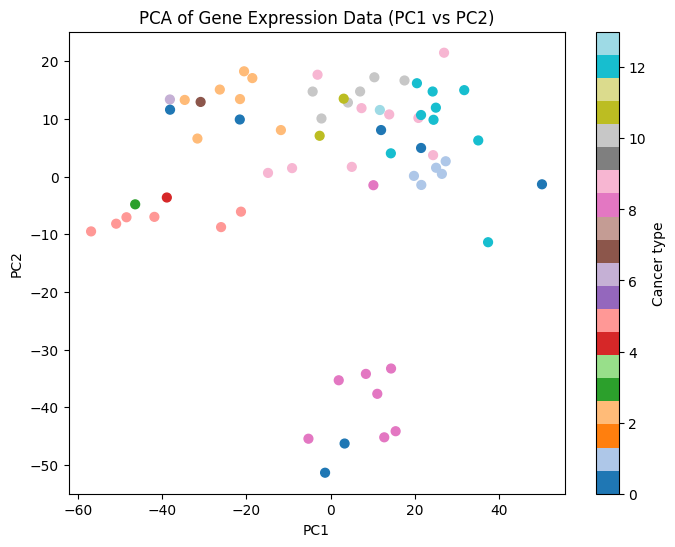

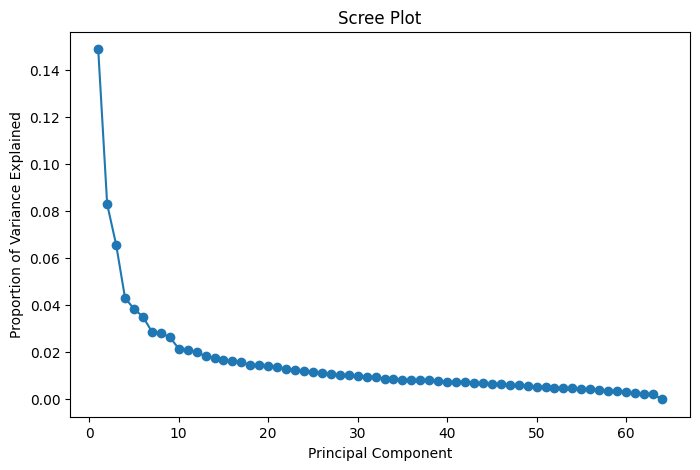

In [28]:
from sklearn.decomposition import PCA

# ===== PCA with first two principal components =====
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_array)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca_2[:, 0],
    X_pca_2[:, 1],
    c=cancer_groups,
    cmap='tab20',
    s=40
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Gene Expression Data (PC1 vs PC2)')
plt.colorbar(label='Cancer type')
plt.show()


# ===== PCA for scree plot =====
pca_full = PCA()
pca_full.fit(X_array)

explained_variance = pca_full.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(explained_variance) + 1),
    explained_variance,
    marker='o'
)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot')
plt.show()


PCA was used to the gene expression data for visualization.
From the scatter plot of PC1 versus PC2, we can see that cell lines from the same cancer type tend to have similar scores and form small groups. However, there is still overlap between different cancer types, which means the first two principal components cannot fully separate all classes.
From the scree plot, we find that the first few principal components explain a large proportion of the variance. After that, the explained variance decreases quickly and then becomes more stable. An elbow can be seen around the 5th principal component, which suggests that about 5 components are sufficient to capture the main structure of the data.

# Hierarchical Clustering: Gene Expression Data <a id='hc_genedata'></a>

Now, let's perform hierarchical clustering on the gene expression data. 

### 🚩 Exercise 11 (CORE)

a) Plot the dendrogram with complete, single, and average linkage. Does the choice of linkage affect the results? Which linkage would you choose?

In [ ]:
methods = ["complete", "single", "average"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, m in zip(axes, methods):
    Z = hierarchy.linkage(X_array, method=m, metric="euclidean")
    hierarchy.dendrogram(Z, ax=ax, no_labels=True, color_threshold=None, above_threshold_color="black")
    ax.set_title(f"{m.capitalize()} linkage")
    ax.set_xlabel("Samples")
    ax.set_ylabel("Height")

plt.tight_layout()
plt.show()


Yes，the choice of linkage affects the dendrogram structure and the resulting clustering. Single linkage often shows a chaining effect (clusters merge early through nearest-neighbour connections), while complete and average linkage tend to produce more compact, interpretable clusters. I would typically choose average linkage (or complete) for gene expression data because it is less sensitive to chaining and usually yields more stable, balanced clusters.

b) Select a linkage and a number of clusters (by examining the dendrogram and jumps in the heights of the clusters merged). Plot the dendogram and color the branches to identify the clusters. Use the option `labels = np.asarray(y_clean), leaf_font_size=10` in `hierarchy.dendrogram` to add the cancer types as labels for each data point. Do you observe any patterns between the clusters and cancer types? You may also want to use `pd.crosstab` to compute a cross-tabulation to compare the clusters and cancer types.

In [ ]:
method = "average"   
Z = hierarchy.linkage(X_array, method=method, metric="euclidean")

k = 4          

cluster_labels = hierarchy.cut_tree(Z, n_clusters=k).flatten()

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
hierarchy.dendrogram(
    Z,
    ax=ax,
    labels=np.asarray(y_clean),   
    leaf_font_size=10,
    color_threshold=None,
    above_threshold_color="black"
)
ax.set_title(f"Dendrogram ({method} linkage) with cancer type labels")
ax.set_xlabel("Samples (cancer type)")
ax.set_ylabel("Height")
plt.tight_layout()
plt.show()

print(f"Chosen linkage: {method}, number of clusters: {len(np.unique(cluster_labels))}")

ct = pd.crosstab(pd.Series(cluster_labels, name="Cluster"),
                 pd.Series(y_clean, name="Cancer type"))
display(ct)

dominant = ct.idxmax(axis=1)
dominant_counts = ct.max(axis=1)
cluster_sizes = ct.sum(axis=1)
summary = pd.DataFrame({
    "Dominant cancer type": dominant,
    "Dominant count": dominant_counts,
    "Cluster size": cluster_sizes,
    "Dominant fraction": (dominant_counts / cluster_sizes).round(3)
})
display(summary)

Using average linkage, I cut the dendrogram into 4 clusters. The resulting clusters show only a weak correspondence with the cancer-type labels. The cross-tabulation indicates that:Cluster 0 is a large mixed cluster (54 samples) containing many different cancer types; its dominant label is RENAL (9/54 ≈ 0.167), so it is not a “pure” cancer-type cluster.Cluster 2 is the most coherent: it is enriched for LEUKEMIA (5/7 ≈ 0.714) and also contains the K562A/K562B replicates, suggesting these leukemia-related samples cluster together.Cluster 3 contains a single sample (a singleton cluster), labeled LEUKEMIA (1/1).Cluster 1 is very small (2 samples) and is split between BREAST (1) and NSCLC (1), so it does not correspond strongly to one cancer type.
Overall, hierarchical clustering with average linkage captures some structure (especially for LEUKEMIA/K562), but most cancer types are mixed within the large cluster, indicating that the unsupervised clusters do not perfectly align with the provided cancer labels for this dataset and chosen cut.

🏁 **Now, is a good point to switch driver and navigator**

# K-means Clustering: Gene Expression Data <a id='kmeans_genedata'></a>

Now, let's perform k-means clustering on the gene expression data.

### 🚩 Exercise 12 (CORE)

Perform K-means clustering with the same number of clusters that you selected for hierarchical clustering. Are the results similar?

In [ ]:
K = 4

km = KMeans(n_clusters=K, init="k-means++", n_init=20, random_state=0)
km_labels = km.fit_predict(X_array)

ct_km = pd.crosstab(pd.Series(km_labels, name="KMeans cluster"),
                    pd.Series(y_clean, name="Cancer type"))
display(ct_km)

dominant_km = ct_km.idxmax(axis=1)
dominant_counts_km = ct_km.max(axis=1)
cluster_sizes_km = ct_km.sum(axis=1)
summary_km = pd.DataFrame({
    "Dominant cancer type": dominant_km,
    "Dominant count": dominant_counts_km,
    "Cluster size": cluster_sizes_km,
    "Dominant fraction": (dominant_counts_km / cluster_sizes_km).round(3)
})
display(summary_km)

Z_avg = hierarchy.linkage(X_array, method="average", metric="euclidean")
hc_labels = hierarchy.cut_tree(Z_avg, n_clusters=K).flatten()

ct_km_vs_hc = pd.crosstab(pd.Series(hc_labels, name="Hierarchical cluster"),
                          pd.Series(km_labels, name="KMeans cluster"))
display(ct_km_vs_hc)

from sklearn.decomposition import PCA
scores2 = PCA(n_components=2).fit_transform(X_array)

plt.figure(figsize=(7,6))
plt.scatter(scores2[:,0], scores2[:,1], c=km_labels, cmap="tab10", s=35, alpha=0.85)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means clusters (K=4) shown in PCA space")
plt.grid(True, alpha=0.2)
plt.show()


I ran K-means with K = 4, matching the number of clusters used in hierarchical clustering. The results are partially similar but not identical. Both methods recover some consistent structure (e.g., a subset of samples tends to group together across methods), but there are also noticeable differences in how the remaining samples are partitioned. This is expected because hierarchical clustering (with average linkage) and K-means optimize different objectives: hierarchical clustering depends on pairwise distances and linkage rules, while K-means minimizes within-cluster squared distances to centroids and tends to favor roughly spherical, centroid-based clusters. As a result, agreement is moderate rather than perfect, and some clusters are mixed with respect to cancer types in both approaches.

### 🚩 Exercise 13 (EXTRA)

Plot the two clustering solutions along with a plot of the data colored by the cancer types in the space spanned by the first two principal components.

In [ ]:
from sklearn.decomposition import PCA


pca2 = PCA(n_components=2)
scores2 = pca2.fit_transform(X_array)  # (64,2)


K = 4
Z_avg = hierarchy.linkage(X_array, method="average", metric="euclidean")
hc_labels = hierarchy.cut_tree(Z_avg, n_clusters=K).flatten()


km = KMeans(n_clusters=K, init="k-means++", n_init=20, random_state=0)
km_labels = km.fit_predict(X_array)


fig, axes = plt.subplots(1, 3, figsize=(18, 5))


axes[0].scatter(scores2[:,0], scores2[:,1], c=cancer_groups, cmap="tab10", s=40, alpha=0.85)
axes[0].set_title("PC1–PC2 colored by cancer type")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].grid(True, alpha=0.2)


axes[1].scatter(scores2[:,0], scores2[:,1], c=hc_labels, cmap="tab10", s=40, alpha=0.85)
axes[1].set_title("PC1–PC2 colored by hierarchical clusters (K=4)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].grid(True, alpha=0.2)


axes[2].scatter(scores2[:,0], scores2[:,1], c=km_labels, cmap="tab10", s=40, alpha=0.85)
axes[2].set_title("PC1–PC2 colored by K-means clusters (K=4)")
axes[2].set_xlabel("PC1")
axes[2].set_ylabel("PC2")
axes[2].grid(True, alpha=0.2)

plt.tight_layout()
plt.show()


# Competing the Worksheet

At this point you have hopefully been able to complete all the CORE exercises and attempted the EXTRA ones. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Before generating the PDF, please **change 'Student 1' and 'Student 2' at the top of the notebook to include your name(s)**.

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF.

In [ ]:
!jupyter nbconvert --to pdf mlp_week03.ipynb 